In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
# import numpy as np
import shutil
import os
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 58422852 (222.87 MB)
Trainable params: 51385348 (196.02 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 9.0600 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 29s 16s/step - loss: 9.0600 - accuracy: 0.3333 - val_loss: 5.5905 - val_accuracy: 0.2857
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 9.4782 - accuracy: 0.2917
Epoch 2: val_accuracy improved from 0.28571 to 0.42857, saving model to densenet_model.h5
2/2 [==============================] - 4s 4s/step - loss: 9.4782 - accuracy: 0.2917 - val_loss: 4.4299 - val_accuracy: 0.4286
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 6.1291 - accuracy: 0.2917
Epoch 3: val_accuracy improved from 0.42857 to 0.71429, saving model to densenet_model.h5
2/2 [==============================] - 6s 6s/step - loss: 6.1291 - accuracy: 0.2917 - val_loss: 3.4267 - val_accuracy: 0.7143
Epoch 4/50
2/2 [==============================] - ETA: 0s - loss: 5.3812 - accuracy: 0.5000
Epoch 4: val_accuracy did not improve from 0.71429
2/2 [==============================] - 1s 334ms/step - loss: 5.3812 - accuracy: 0.5000 - val_loss: 3.5875 - val_a

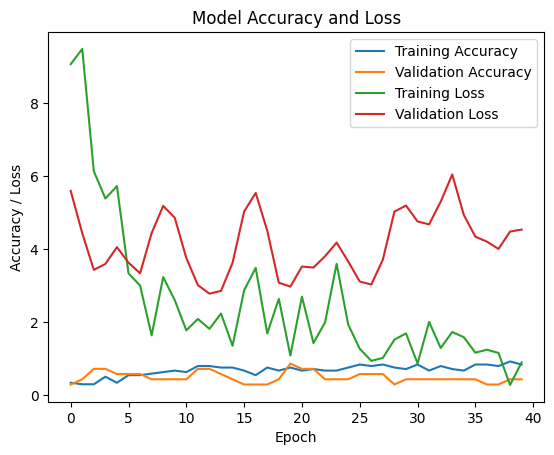

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.applications import DenseNet121  # Changed from ResNet50 to DenseNet121


# Load the CSV file
data = pd.read_csv('/content/drive/MyDrive/Dataset/Lung_disease/map(1).csv')

# Extract filenames and corresponding outputs
filenames = data['Filename'].tolist()
outputs = data['Damage'].tolist()

# Load and resize images
images = []
for filename in filenames:
    img = cv2.imread(f"/content/drive/MyDrive/Dataset/Lung_disease/images_cropped_half-20240617T042553Z-001/Cropped_segment/{filename}")
    img = cv2.resize(img, (224, 224))  # Resize image to fit DenseNet input shape
    images.append(img)
images = np.array(images)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, outputs, test_size=0.2, random_state=42)

# Label encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Convert labels to categorical one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes=4)
y_test = keras.utils.to_categorical(y_test, num_classes=4)

# Build the DenseNet model
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Changed from ResNet50 to DenseNet121

# Adding custom layers on top of DenseNet
model = Sequential()
model.add(densenet_model)
model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

# Freeze the DenseNet layers
for layer in densenet_model.layers:
    layer.trainable = False

# Compile the model
opt = Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Training callbacks
checkpoint = ModelCheckpoint("densenet_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')  # Changed from "resnet_model.h5" to "densenet_model.h5"
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

# Image data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training data generator
train_data = train_datagen.flow(X_train, y_train, batch_size=16)

# Train the model
hist = model.fit(train_data, validation_data=(X_test, y_test), epochs=50, callbacks=[checkpoint, early])

# Visualize the training results
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Accuracy and Loss")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy", "Validation Accuracy", "Training Loss", "Validation Loss"])
plt.show()


In [4]:
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report

# Load the saved model
best_model = load_model("densenet_model.h5")

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Validation Accuracy: {accuracy:.2f}")

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)


1/1 [==============================] - 2s 2s/step
Validation Accuracy: 0.86
               precision    recall  f1-score   support

Medium damage       0.75      1.00      0.86         3
  Mild damage       1.00      1.00      1.00         2
    No damage       1.00      1.00      1.00         1
Severe damage       0.00      0.00      0.00         1

     accuracy                           0.86         7
    macro avg       0.69      0.75      0.71         7
 weighted avg       0.75      0.86      0.80         7



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
